In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_trump = pd.read_csv("parsed_trump.csv")
df_biden = pd.read_csv("parsed_biden.csv")
df_biden.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
2,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132
3,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,"Illinois, home of Lincoln and Reagan, used to ...",...,1397.0,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States of America,North America,Illinois,IL,2020-10-21 00:00:03.106963698
4,2020-10-15 00:00:57,1.316529e+18,"FBI Allegedly Obtained Hunter Biden Computer, ...",0.0,0.0,Twitter for Android,9.607387e+17,RLCompton,NewfoundStudio,"""There are things known and there are things u...",...,266.0,"Kentucky, USA",37.572603,-85.155141,NaN,United States of America,North America,Kentucky,KY,2020-10-21 00:00:05.696100113


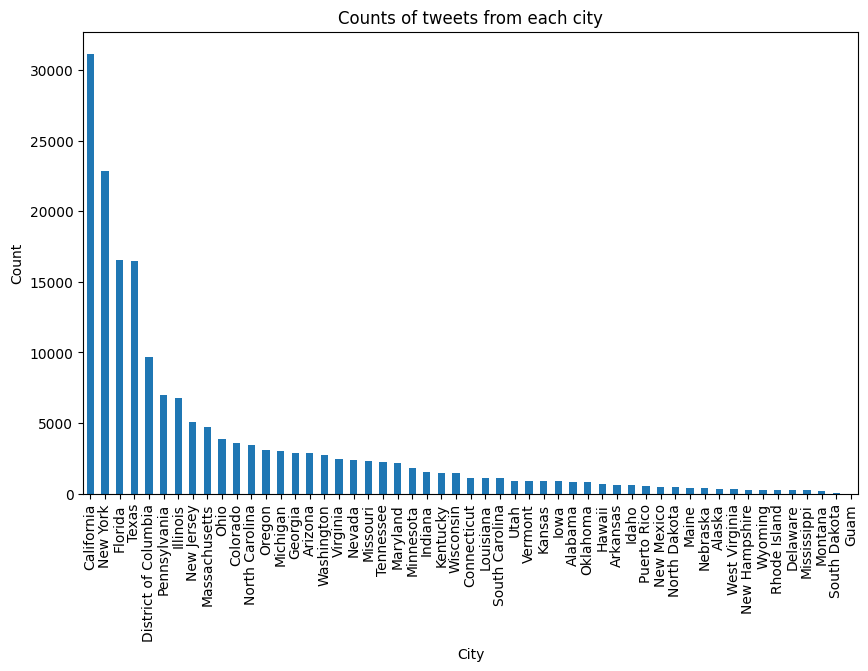

In [4]:
value_counts_trump = df_trump['state'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Plotting the counts
value_counts_trump.plot(kind='bar')
plt.title('Counts of tweets from each city')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

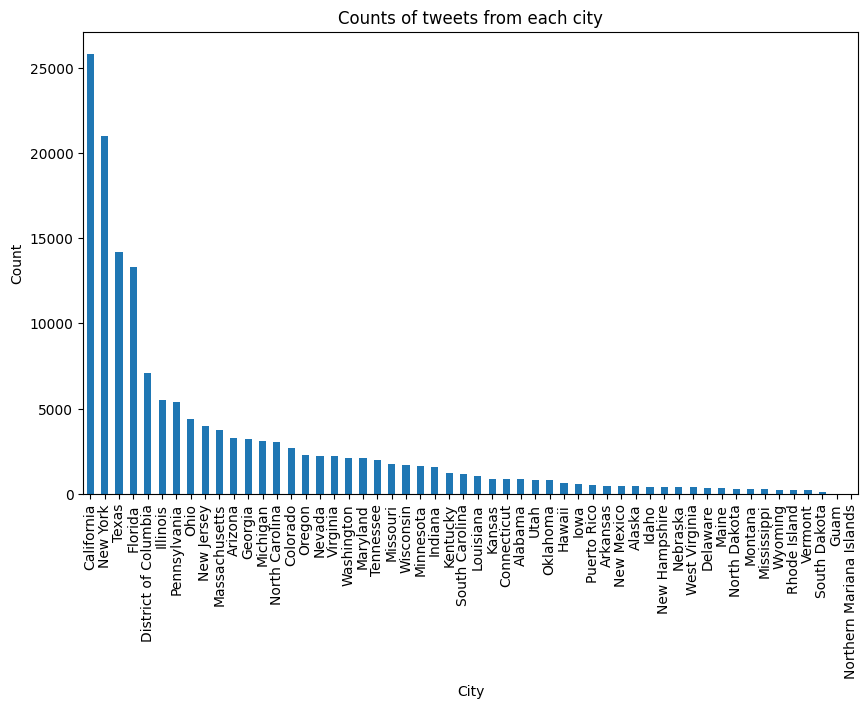

In [5]:
value_counts_biden = df_biden['state'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Plotting the counts
value_counts_biden.plot(kind='bar')
plt.title('Counts of tweets from each city')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

In [6]:
df_sentiment_trump = pd.read_csv("tweets_sentiment_analysis_trump.csv")
df_sentiment_trump.head()

# Assign a sentiment category based on the highest probability score
df_sentiment_trump['Dominant_Sentiment'] = df_sentiment_trump[['Negative', 'Neutral', 'Positive']].idxmax(axis=1)

# Group by 'state' and count the number of occurrences of each sentiment
sentiment_counts_per_state = df_sentiment_trump.groupby(['state', 'Dominant_Sentiment']).size().unstack(fill_value=0)

print(sentiment_counts_per_state)


Dominant_Sentiment    Negative  Neutral  Positive
state                                            
Alabama                    398      331       120
Alaska                     133      142        36
Arizona                   1513      926       426
Arkansas                   377      199        37
California               18565     9718      2865
Colorado                  2168     1163       287
Connecticut                670      349       122
Delaware                   118       94        33
District of Columbia      4303     4583       798
Florida                   8326     6329      1903
Georgia                   1391     1136       349
Hawaii                     395      224        87
Idaho                      402      163        43
Illinois                  4139     2045       593
Indiana                    998      385       173
Iowa                       564      239        77
Kansas                     487      287       126
Kentucky                   832      490       162


In [7]:
# Normalize the likes and retweets on a state-wise basis
def normalize_statewise(group):
    max_likes = group['likes'].max()
    max_retweets = group['retweet_count'].max()# Normalize the likes and retweets on a state-wise basis
def normalize_statewise(group):
    total_likes = group['likes'].sum()
    total_retweets = group['retweet_count'].sum()
    
    # Avoid division by zero
    group['State_Normalized_Likes'] = (group['likes'] / total_likes if total_likes != 0 else 0) * 100
    group['State_Normalized_Retweets'] = (group['retweet_count'] / total_retweets if total_retweets != 0 else 0) * 100
    
    return group

# Apply the normalization function to each state group and reset the index
df_normalized = df_sentiment_trump.groupby('state').apply(normalize_statewise).reset_index(drop=True)

# Define a function to calculate the weighted sentiment score
def calculate_weighted_score(row):
    # Check if the sentiment is positive or negative, and ignore neutral
    if row['Dominant_Sentiment'] == 'Positive':
        sentiment_score = 1
    elif row['Dominant_Sentiment'] == 'Negative':
        sentiment_score = -1
    else:
        # Return NaN for neutral to exclude it from the mean calculation later
        return np.nan
    
    # Define weights for likes and retweets
    likes_weight = 0.6  # Example weight for likes
    retweets_weight = 0.4  # Example weight for retweets

    # Calculate the weighted score using the normalized values with different weights
    weighted_score = sentiment_score * ((row['State_Normalized_Likes'] * likes_weight) + (row['State_Normalized_Retweets'] * retweets_weight))
    return weighted_score

# Apply the function to each row of the normalized dataframe
df_normalized['Weighted_Sentiment_Score'] = df_normalized.apply(calculate_weighted_score, axis=1)

# Now group by 'state' without setting it as an index
state_sentiment = df_normalized.groupby('state', as_index=False)['Weighted_Sentiment_Score'].mean()





# Find the minimum non-zero values for 'likes' and 'retweets'
min_likes = df_sentiment_trump[df_sentiment_trump['likes'] > 0]['likes'].min()
min_retweets = df_sentiment_trump[df_sentiment_trump['retweet_count'] > 0]['retweet_count'].min()

print(min_likes, min_retweets)


1.0 1.0


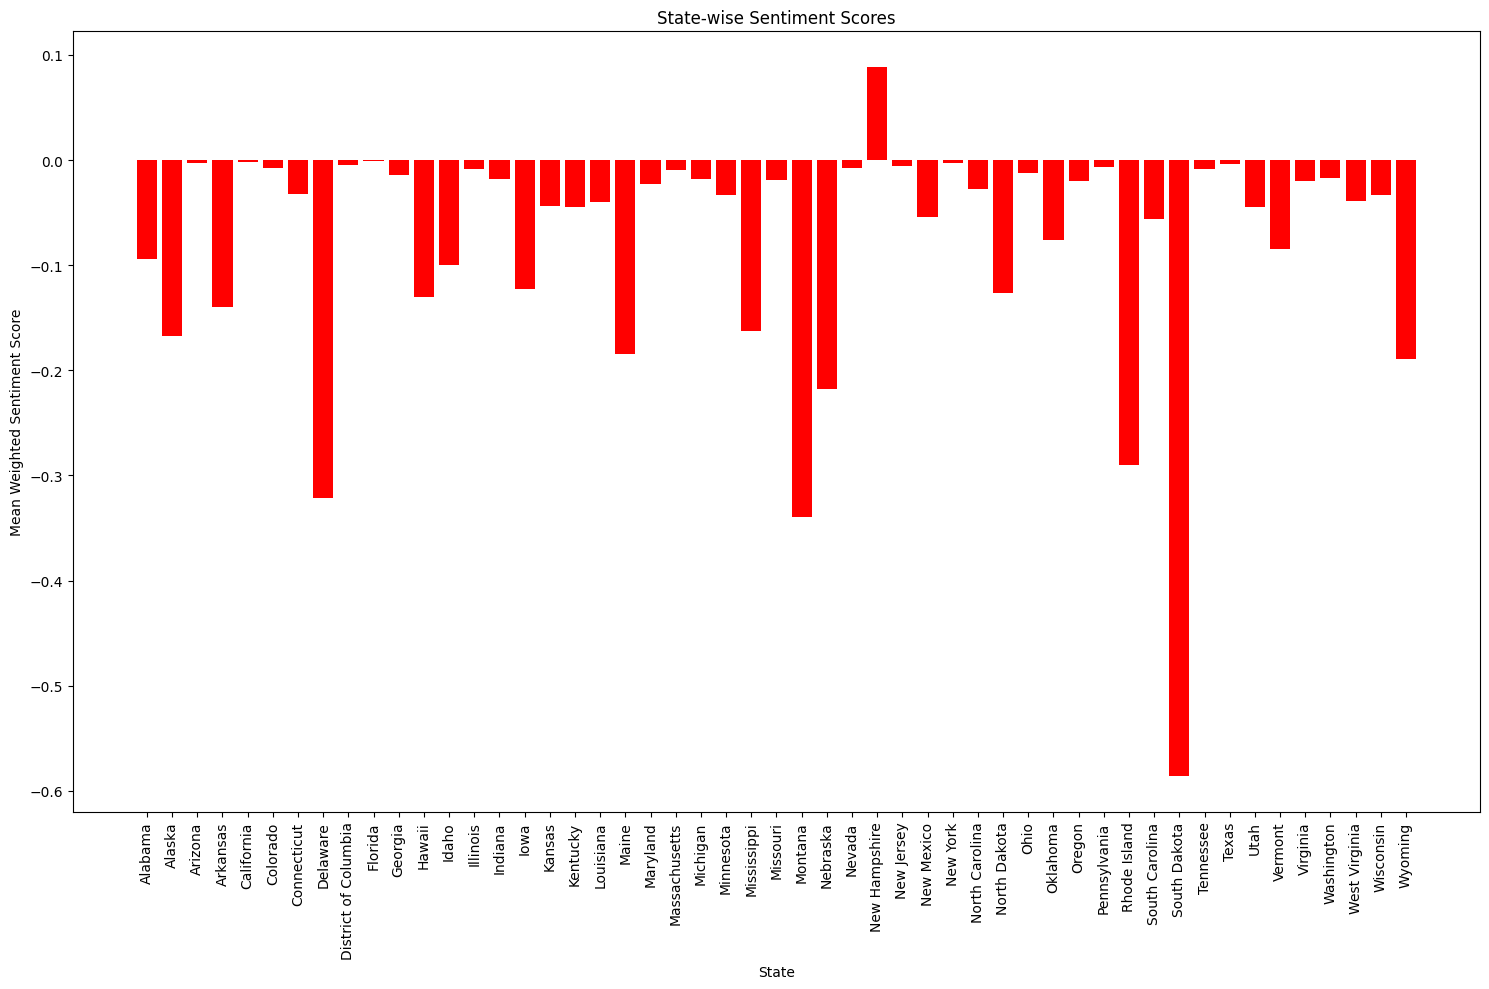

In [8]:
# Create a bar plot
plt.figure(figsize=(15, 10))  # Adjust the size as needed
plt.bar(state_sentiment['state'], state_sentiment['Weighted_Sentiment_Score'], color='red')

# Add title and labels
plt.title('State-wise Sentiment Scores')
plt.xlabel('State')
plt.ylabel('Mean Weighted Sentiment Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()  # Adjust subplot params so that the subplot(s) fits in to the figure area
plt.show()

In [9]:
state_sentiment.to_csv("state_sentiment_scores_trump_negativity_bias.csv", index=False)

In [10]:
df_sentiment_trump["state"].unique()

array(['New York', 'District of Columbia', 'California', 'Pennsylvania',
       'North Carolina', 'Illinois', 'Florida', 'New Jersey', 'Texas',
       'Michigan', 'Massachusetts', 'Arizona', 'Louisiana', 'Connecticut',
       'Rhode Island', 'Virginia', 'Indiana', 'Colorado',
       'South Carolina', 'Tennessee', 'Kansas', 'Maryland', 'Kentucky',
       'Minnesota', 'Nevada', 'Nebraska', 'Missouri', 'Alabama',
       'Georgia', 'Iowa', 'New Hampshire', 'Wisconsin', 'Mississippi',
       'Ohio', 'Hawaii', 'Washington', 'West Virginia', 'Maine',
       'Vermont', 'Oklahoma', nan, 'New Mexico', 'Utah', 'Arkansas',
       'Oregon', 'Alaska', 'Idaho', 'North Dakota', 'Wyoming', 'Montana',
       'South Dakota', 'Delaware'], dtype=object)

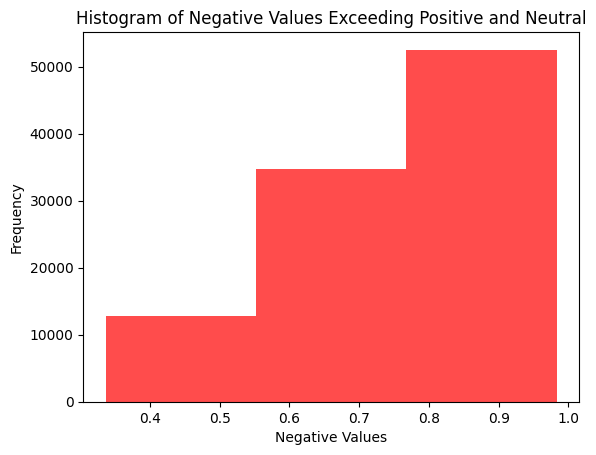

100032


In [18]:
# Filtering the rows where the 'Negative' value is higher than both 'Positive' and 'Neutral'
filtered_df = df_sentiment_trump[df_sentiment_trump['Negative'] > df_sentiment_trump[['Positive', 'Neutral']].max(axis=1)]

# Plotting the histogram for the 'Negative' column in the filtered DataFrame
plt.hist(filtered_df['Negative'], bins=3, color='red', alpha=0.7)
plt.xlabel('Negative Values')
plt.ylabel('Frequency')
plt.title('Histogram of Negative Values Exceeding Positive and Neutral')
plt.show()
print(len(filtered_df))
